In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# defining the model 
class PINN(nn.Module): 
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 2)])
        self.output_layer = nn.Linear(layers[-2], layers[-1])
        self.activation = nn.Tanh()

        # Initialize weights 
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, X):   
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        return self.output_layer(X)


In [22]:
# Generate training data
def generate_data():

    x = np.linspace(0,1,100)[:, None] #spatial domain
    t = np.linspace(0,1,100)[:, None] # time domain 

    X, T = np.meshgrid(x, t)
    X_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

    return torch.tensor(X_train, dtype=torch.float32, requires_grad=True)


In [23]:
def compute_Loss(model, X, alpha=0.05): 

    x = X[:, 0:1].requires_grad_(True)
    t = X[:, 1:2].requires_grad_(True)

    X = torch.cat((x, t), dim=1)
    u = model(X)

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    pde_residual = u_t - alpha * u_xx
    loss_pde = torch.mean(pde_residual**2)

    # Boundary condition: u(0, t) = u(1, t) = 0
    x_bc = torch.tensor([[0], [1]], dtype=torch.float32).repeat(100, 1)
    t_bc = torch.linspace(0, 1, 100).repeat(2, 1).T.flatten()[:, None]
    X_bc = torch.cat((x_bc, t_bc), dim=1)
    loss_bc = torch.mean(model(X_bc)**2)

    # Initial condition: u(x, 0) = sin(pi*x)
    x_ic = torch.linspace(0, 1, 100)[:, None]
    t_ic = torch.zeros_like(x_ic)
    X_ic = torch.cat((x_ic, t_ic), dim=1)
    u_ic = torch.sin(np.pi * x_ic)
    loss_ic = torch.mean((model(X_ic) - torch.tensor(u_ic, dtype=torch.float32))**2)

    return loss_bc + loss_ic + loss_pde


In [24]:
def train_PINN_model(model, X_train, epochs=5000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        loss = compute_Loss(model, X_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")



C:\Users\Hossein\AppData\Local\Temp\ipykernel_2516\2582798809.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ic = torch.mean((model(X_ic) - torch.tensor(u_ic, dtype=torch.float32))**2)


Epoch 0, Loss: 0.7993574142456055
Epoch 500, Loss: 0.0014453845797106624
Epoch 1000, Loss: 0.0002760850475169718
Epoch 1500, Loss: 0.00015061258454807103
Epoch 2000, Loss: 0.00010304556781193241
Epoch 2500, Loss: 0.00011854818149004132
Epoch 3000, Loss: 4.8932357458397746e-05
Epoch 3500, Loss: 3.322855627629906e-05
Epoch 4000, Loss: 2.2316149625112303e-05
Epoch 4500, Loss: 1.5160707334871404e-05


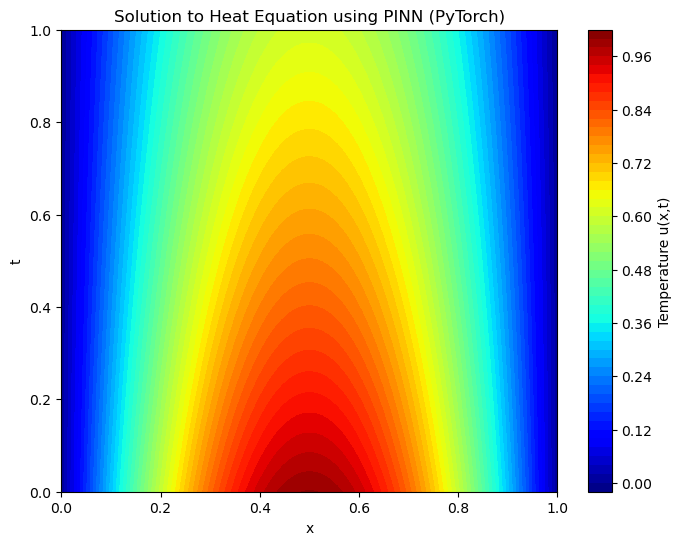

In [25]:
# Running the PINN model
model = PINN(layers=[2, 32, 32, 32, 1])
X_train = generate_data()
train_PINN_model(model, X_train)

#visualization
x_test = np.linspace(0, 1, 100)[:, None]
t_test = np.linspace(0, 1, 100)[:, None]
X_test, T_test = np.meshgrid(x_test, t_test)
X_pred = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
X_pred_tensor = torch.tensor(X_pred, dtype=torch.float32)

U_pred = model(X_pred_tensor).detach().numpy().reshape(100, 100)
plt.figure(figsize=(8, 6))
plt.contourf(X_test, T_test, U_pred, levels=50, cmap='jet')
plt.colorbar(label='Temperature u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to Heat Equation using PINN (PyTorch)')
plt.show()